# <font color='#1a5276'> <b> <center> Initialization </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data](#4)
5. [Model](#5)
6. [Initialization methods](#6) <br>
    6.1. [PyTroch default initialization](#6.1) <br>
    6.2. [Bad initialization](#6.2) <br>
7. [Conclusions](#7)
8. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

Initialization plays a pivotal role in the performance and convergence of AI models. This project aims to demonstrate the significance of proper weight initialization techniques in training deep learning models.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
torch.manual_seed(2)

<a name="3"></a>
## <font color='blue'> <b> 3. Helper Functions </b> </font>

In [4]:
# Create a class to plot error surfaces and analyze parameter optimization during training
class PlotErrorSurfaces(object):
    
    # Constructor initializes the error surface and optional 3D/contour plots
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        # Generate evenly spaced values for weights (W) and biases (B) within the specified range
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        # Create a grid of weight (w) and bias (b) values
        w, b = np.meshgrid(W, B)    
        # Initialize a matrix to store loss values
        Z = np.zeros((30, 30))
        count1 = 0
        # Convert input tensors X and Y to NumPy arrays for computations
        self.y = Y.numpy()
        self.x = X.numpy()
        # Calculate the mean squared error loss for all weight and bias combinations
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - (1 / (1 + np.exp(-1*w2 * self.x - b2)))) ** 2)
                count2 += 1   
            count1 += 1
        # Store computed loss surface and parameter grids as class attributes
        self.Z = Z
        self.w = w
        self.b = b
        # Initialize lists to store training parameter values and loss history
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        # Optionally display 3D and contour plots of the loss surface
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    # Method to record the current parameters and their corresponding loss during training
    def set_para_loss(self, model, loss):
        self.n = self.n + 1  # Increment iteration count
        # Append the current weight and bias values from the model
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        # Append the current loss value
        self.LOSS.append(loss)
    
    # Method to generate final plots of the loss surface and training path
    def final_plot(self): 
        # Create a 3D wireframe plot of the loss surface
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        # Overlay the path of parameter updates on the 3D plot
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        # Create a contour plot of the loss surface
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        # Overlay the parameter update path on the contour plot
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Method to plot the data space and loss surface at the current iteration
    def plot_ps(self):
        # Plot the data points and model predictions in the data space
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label='sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        # Plot the contour of the loss surface with parameter update path
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')


<a name="4"></a>
## <font color='blue'> <b> 4. Data </b> </font>

We will create synthetic data. The data corresponds a logistic regression problem.

In [5]:
# Define a custom dataset class by extending PyTorch's Dataset
class Data(Dataset):
    
    # Constructor: initializes the dataset
    def __init__(self):
        # Create input data (x) as values ranging from -1 to 1 with a step of 0.1, reshaped into a column vector
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        # Initialize target data (y) as zeros with the same number of rows as x
        self.y = torch.zeros(self.x.shape[0], 1)
        # Set y values to 1 where x values are greater than 0.2
        self.y[self.x[:, 0] > 0.2] = 1
        # Store the number of samples in the dataset
        self.len = self.x.shape[0]
        
    # Getter: retrieves a single data point (input and target) by index
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get Length: returns the total number of samples in the dataset
    def __len__(self):
        return self.len


In [6]:
dataset = Data()

<Figure size 640x480 with 0 Axes>

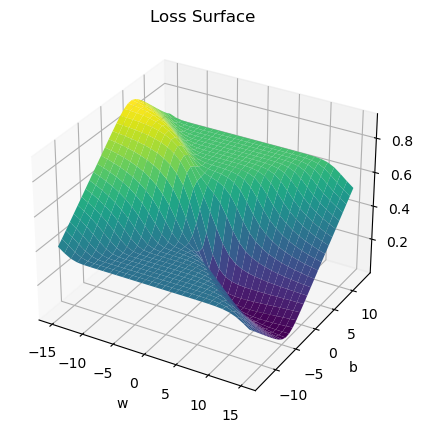

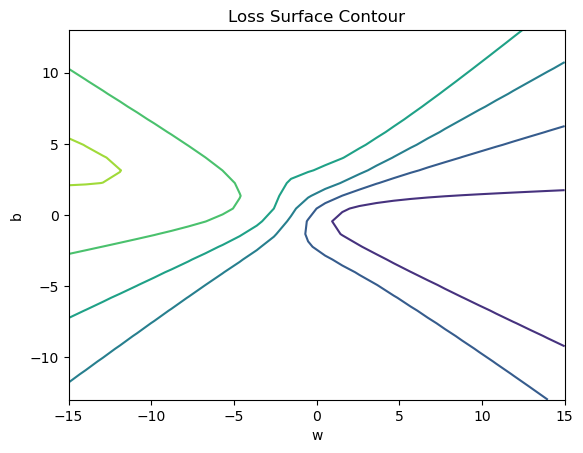

In [7]:
# Create the plot_error_surfaces object
get_surface = PlotErrorSurfaces(15, 13, dataset[:][0], dataset[:][1], 30)

<a name="5"></a>
## <font color='blue'> <b> 5. Model </b> </font>

In [8]:
# Create a Logistic Regression class

class LogisticRegression(nn.Module):
    
    # constructor
    def __init__(self, n_inputs):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # forward pass
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat


In [9]:
# Create dataloader object
trainloader = DataLoader(dataset = dataset, batch_size = 3)

In [10]:
# learning rate
learning_rate = 0.01

In [11]:
# train the model
def train_model(model, trainloader, criterion, optimizer, epochs):
    for epoch in range(epochs):  # Loop over the number of epochs
        for x, y in trainloader:  # Loop through the data in the trainloader
            # Forward pass: Compute predictions
            yhat = model(x)
            
            # Compute the loss
            loss = criterion(yhat, y)
            
            # Zero the gradients from the previous step
            optimizer.zero_grad()
            
            # Backward pass: Compute gradients
            loss.backward()
            
            # Update model parameters
            optimizer.step()
            
            # Track loss and parameters for visualization
            get_surface.set_para_loss(model, loss.tolist())
        
        # Periodically visualize the model's progress
        if epoch % 20 == 0:
            get_surface.plot_ps()
    
    # Return the trained model
    return model


In [12]:
# Evaluation
def evaluate_model(model, dataset, threshold=0.5):
    yhat = model(dataset.x)
    label = yhat > threshold
    return torch.mean((label == dataset.y.type(torch.ByteTensor)).type(torch.float))
    


<a name="6"></a>
## <font color='blue'> <b> 6. Initialization methods </b> </font>

<a name="6.1"></a>
### <font color='#2874a6'> <b> 6.1. PyTorch Default Initialization </b> </font>

By default PyTorch uses Kaiming Uniform Initialization.

In [13]:
model_1 = LogisticRegression(1)

In [14]:
list(model_1.parameters())

[Parameter containing:
 tensor([[0.2294]], requires_grad=True),
 Parameter containing:
 tensor([-0.2380], requires_grad=True)]

In [15]:
# optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr = learning_rate)

In [16]:
# criterion
criterion = nn.MSELoss()

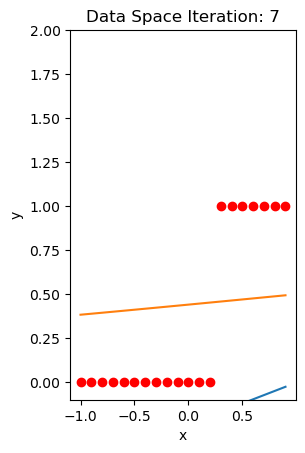

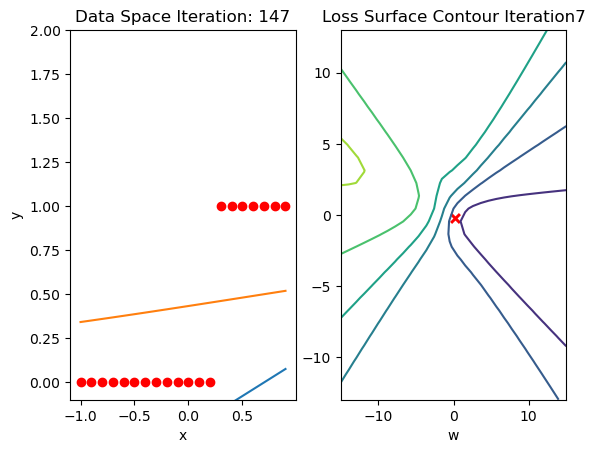

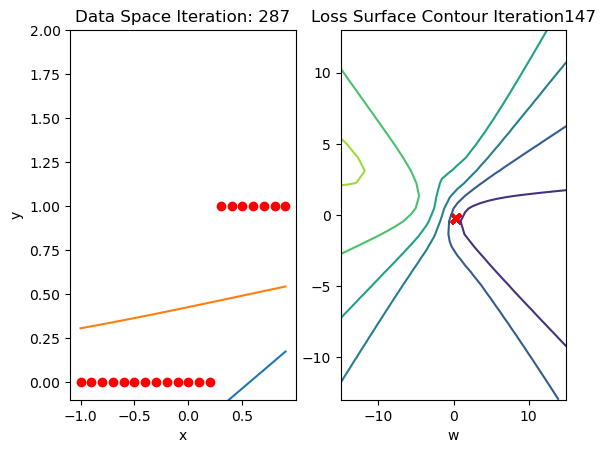

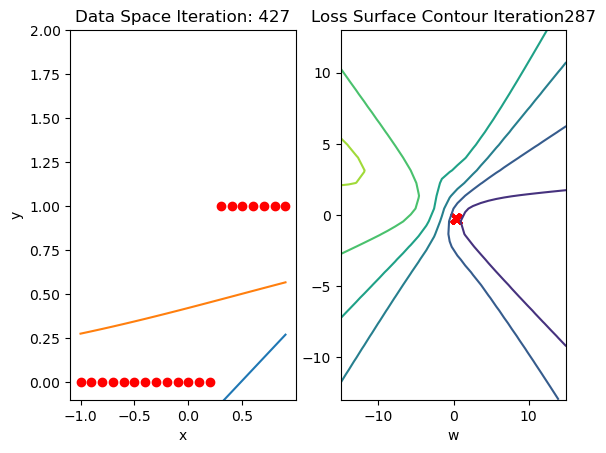

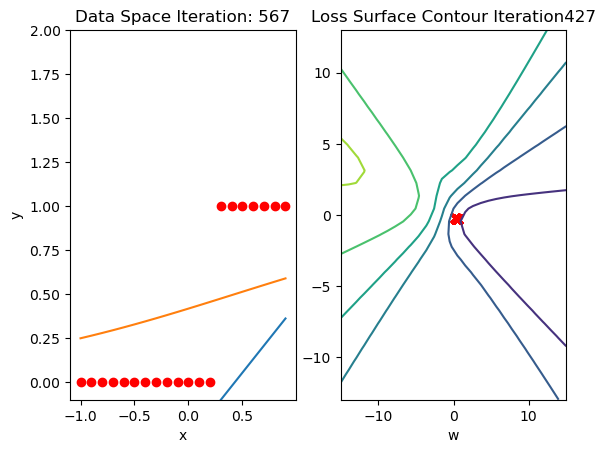

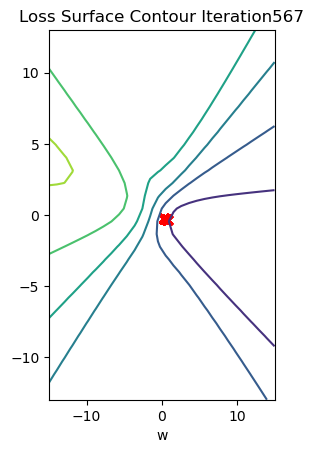

In [17]:
# train
trained_model_1 = train_model(model_1, trainloader, criterion, optimizer, epochs=100)

In [18]:
list(trained_model_1.parameters())

[Parameter containing:
 tensor([[0.8773]], requires_grad=True),
 Parameter containing:
 tensor([-0.3448], requires_grad=True)]

In [19]:
# evaluate
model_1_results = evaluate_model(trained_model_1, dataset)
model_1_results

tensor(0.9500)

<a name="6.2"></a>
### <font color='#2874a6'> <b> 6.2. Bad Initialization </b> </font>

Now, let's initialize the parameters incorrectly on purpose.


In [20]:
# other model
model_2 = LogisticRegression(1)

model_2.state_dict()['linear.weight'].data[0] = torch.tensor([[-5]])
model_2.state_dict()['linear.bias'].data[0] = torch.tensor([[-10]])
print("The parameters: ", model_2.state_dict())


The parameters:  OrderedDict([('linear.weight', tensor([[-5.]])), ('linear.bias', tensor([-10.]))])


In [21]:
# optimizer
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr = learning_rate)

In [22]:
# criterion
criterion = nn.MSELoss()

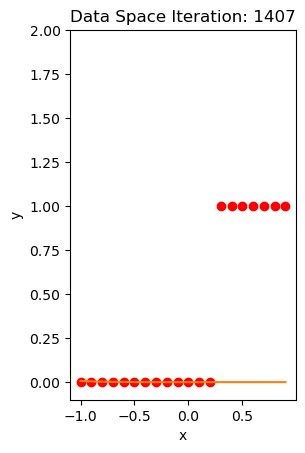

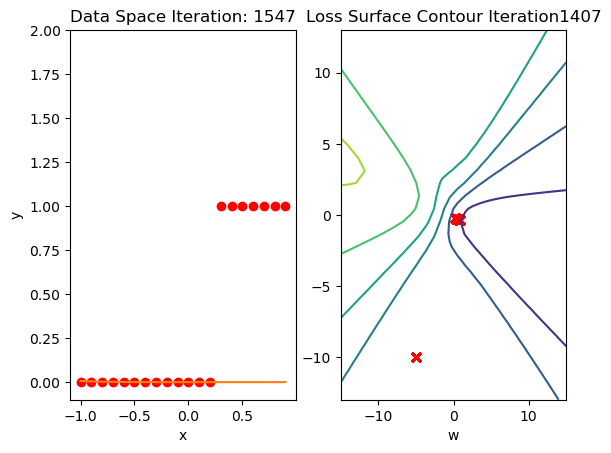

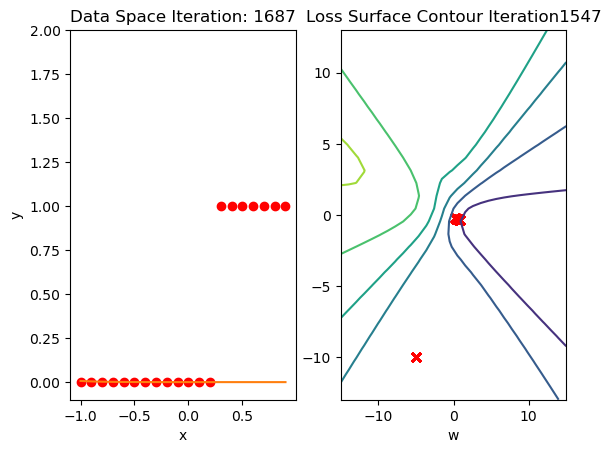

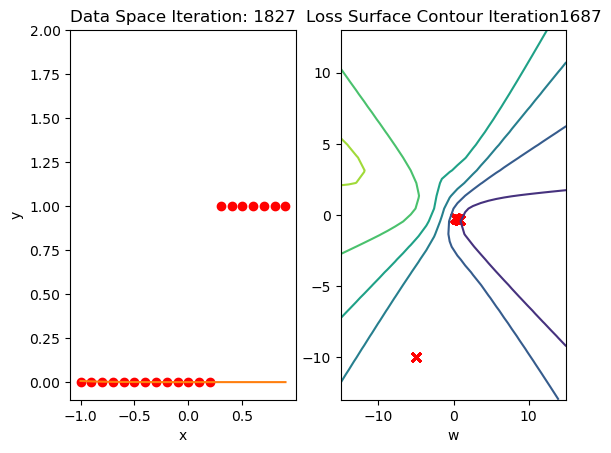

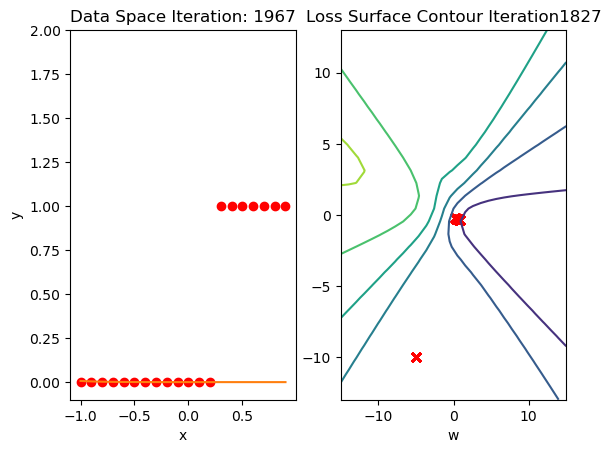

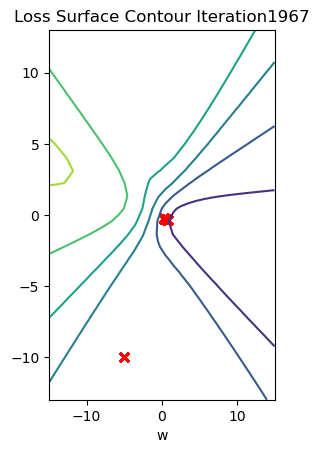

In [26]:
# train
trained_model_2 = train_model(model_2, trainloader, criterion, optimizer_2, 100)

In [27]:
# parameters after training
list(trained_model_2.parameters())

[Parameter containing:
 tensor([[-4.9999]], requires_grad=True),
 Parameter containing:
 tensor([-10.], requires_grad=True)]

In [29]:
# evaluate
model_2_results = evaluate_model(trained_model_2, dataset)
model_2_results

tensor(0.6500)

<a name="7"></a>
## <font color='blue'> <b> 7. Conclusions </b> </font>

We can see that with a good initialization of the parameters, we obtained much better results (95% vs. 65%).

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)

[PyTorch documentation](https://pytorch.org/docs/stable/index.html)